# Plotting change in Elevation along FKC

---

1. Download InSAR data from https://data.cnra.ca.gov/dataset/tre-altamira-insar-subsidence
2. Download line shapefile for FKC from https://gis.water.ca.gov/arcgis/rest/services/InlandWaters/i12_Canals_and_Aqueducts_Federal/MapServer
3. Use FKC shapefile to select the subset of InSAR "point" data (polygons) Note: do this in ArcGIS because the InSAR point data is very large.
4. loop through the vertical displacement point data CSV files to retrieve the timeseries at codes corresponding to the FKC
5. convert FKC line to points and generate new field for distance along the line from the first point
6. spatial join the points with the InSAR "point" data (polygons)
7. plot displacement for dates as a function of distance along the FKC

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pathlib import Path
from shapely.geometry import Point

In [16]:
intera_logo = mpimg.imread(r"C:\Users\hatch\Downloads\full-color-blue-text-gradient-stack-trnspt-med.png")

In [2]:
fkc_shp = "shp/Federal_Canals_and_Aqueducts.shp"
insar_points = "shp/Vertical_Displacement_Point_Data_Locations_2023Q3_FKC.shp"
insar_data = "VerticalDisplacementPointData"

In [3]:
# kings/kaweah boundary 
kkb = "BYM90LO"
# kaweah/tule boundary 
ktb = "BRJFHT2"
# tule/kern boundary 
tkb = "BKQQC3C"

In [4]:
fkc = gpd.read_file(fkc_shp)

In [5]:
fkc_exp = fkc.explode(ignore_index=True)

In [6]:
pt_geometry = []
length = []
distance = 0
for i, row in fkc_exp[::-1].iterrows():
    line = row.geometry
    for pt in line.coords:
        current_pt = Point(pt)
        if len(pt_geometry) > 0:
            distance += current_pt.distance(pt_geometry[-1])
        length.append(distance)
        pt_geometry.append(current_pt)

In [7]:
fkc_pts = gpd.GeoDataFrame(data={"distance_along": length}, geometry=pt_geometry, crs=fkc.crs)

In [8]:
fkc_pts.explore(column="distance_along")

In [9]:
points = gpd.read_file(insar_points)

In [10]:
points.explore(tooltip="CODE")

In [11]:
fkc_pts_w_insar = gpd.sjoin(fkc_pts.to_crs(epsg=4326), points)

In [12]:
fkc_pts_w_insar[fkc_pts_w_insar["CODE"] == kkb]

Empty GeoDataFrame
Columns: [distance_along, geometry, index_right, Join_Count, TARGET_FID, CODE, X, Y, StartDate, DataTable, Shape_Leng, Shape_Area]
Index: []

In [13]:
code = fkc_pts_w_insar["CODE"].unique()
data = []
for item in Path(insar_data).iterdir():
    df = pd.read_csv(item)
    data.append(df.loc[df["CODE"].isin(code)])   

In [14]:
d = pd.concat(data)

In [17]:
data_cols = [col for col in d.columns if "D2" in col]

In [18]:
ds = d.melt(id_vars="CODE", value_vars=data_cols, var_name="Date", value_name="Subsidence")

In [19]:
ds["Date"] = pd.to_datetime(ds["Date"], format="D%Y%m%d")

In [20]:
combined = pd.merge(ds, fkc_pts_w_insar[["CODE", "StartDate", "distance_along", "geometry"]], on="CODE")

In [21]:
fkc_pts_w_insar.groupby("StartDate").size()

StartDate
2015-02-12    1169
2015-02-18      26
2015-02-23      12
2015-03-01       1
2015-03-07       4
2015-03-20       2
2015-05-20      93
2015-05-26       1
2020-10-07     196
2021-10-07       5
2022-07-07       3
dtype: int64

In [22]:
start_date = "2015-02-12"
grouped = combined[combined["StartDate"] == start_date].groupby("CODE")

In [23]:
cleaned_data = pd.DataFrame()
for name, group in grouped:
    tmp = group[group["Date"] >= start_date].sort_values(by="Date").reset_index(drop=True)
    
    # Find the index of the first null value in the time series column of the group
    if tmp["Subsidence"].isnull().any():
        first_null_index = tmp['Subsidence'].isnull().idxmax()
   
        # Slice the group to keep values only up to the index of the first null value
        cleaned_group = tmp.iloc[:first_null_index]
    
    else:
        cleaned_group = tmp.copy()
    
    # Append the cleaned group to the cleaned_data DataFrame
    cleaned_data = pd.concat([cleaned_data, cleaned_group])

# Plotting

(-0.5, 874.5, 408.5, -0.5)

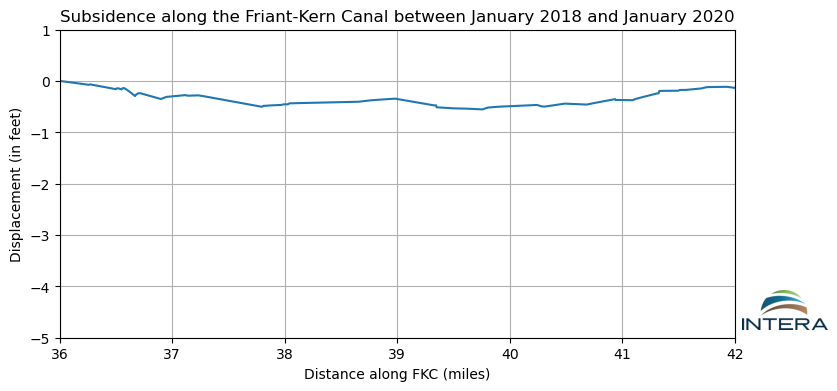

In [47]:
dt1 = pd.to_datetime("2018-01-01")
dt2 = pd.to_datetime("2020-01-01")
dplt1 = cleaned_data[cleaned_data["Date"] == dt1].sort_values(by="distance_along")
dplt2 = cleaned_data[cleaned_data["Date"] == dt2].sort_values(by="distance_along")
dplt = pd.merge(dplt1, dplt2, on="distance_along", suffixes=("_1", "_2"))
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dplt["distance_along"]/5280, (dplt["Subsidence_2"] - dplt["Subsidence_1"])/25.4/12)
    
# format plot
ax.set_title(f"Subsidence along the Friant-Kern Canal between {dt1.strftime('%B %Y')} and {dt2.strftime('%B %Y')}")
ax.set_xlabel("Distance along FKC (miles)")
ax.set_ylabel("Displacement (in feet)")
ax.set_ylim(-5, 1)
ax.set_xlim(36, 42)
ax.grid()

fig.subplots_adjust(right=0.8)

lax = fig.add_axes([0.8, 0.13, 0.1, 0.1])
lax.imshow(intera_logo)
lax.axis("off")

(-0.5, 874.5, 408.5, -0.5)

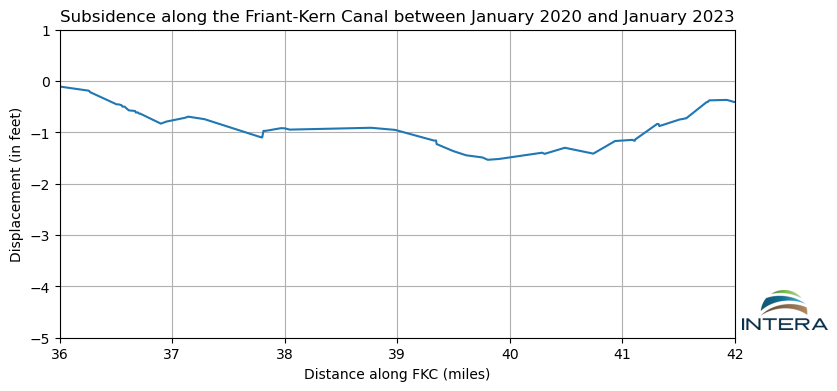

In [48]:
dt1 = pd.to_datetime("2020-01-01")
dt2 = pd.to_datetime("2023-01-01")
dplt1 = cleaned_data[cleaned_data["Date"] == dt1].sort_values(by="distance_along")
dplt2 = cleaned_data[cleaned_data["Date"] == dt2].sort_values(by="distance_along")
dplt = pd.merge(dplt1, dplt2, on="distance_along", suffixes=("_1", "_2"))
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dplt["distance_along"]/5280, (dplt["Subsidence_2"] - dplt["Subsidence_1"])/25.4/12)
    
# format plot
ax.set_title(f"Subsidence along the Friant-Kern Canal between {dt1.strftime('%B %Y')} and {dt2.strftime('%B %Y')}")
ax.set_xlabel("Distance along FKC (miles)")
ax.set_ylabel("Displacement (in feet)")
ax.set_ylim(-5, 1)
ax.set_xlim(36, 42)
ax.grid()

fig.subplots_adjust(right=0.8)

lax = fig.add_axes([0.8, 0.13, 0.1, 0.1])
lax.imshow(intera_logo)
lax.axis("off")

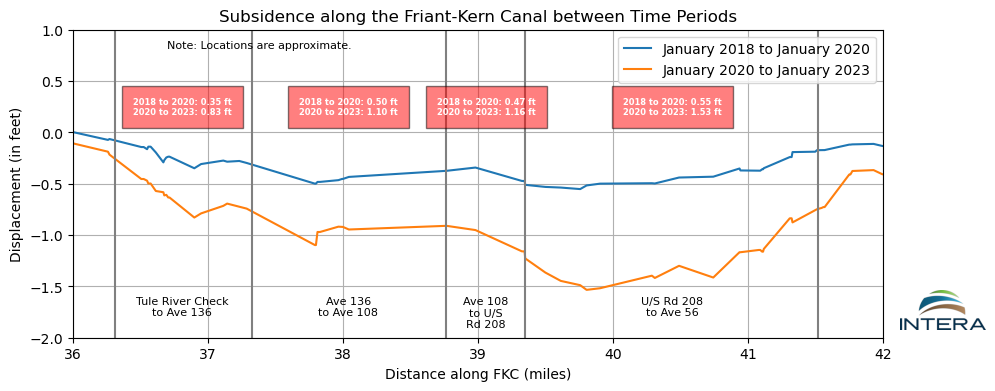

In [46]:
dt1 = pd.to_datetime("2018-01-01")
dt2 = pd.to_datetime("2020-01-01")
dt3 = pd.to_datetime("2023-01-01")
dplt1 = cleaned_data[cleaned_data["Date"] == dt1].sort_values(by="distance_along")
dplt2 = cleaned_data[cleaned_data["Date"] == dt2].sort_values(by="distance_along")
dplt3 = cleaned_data[cleaned_data["Date"] == dt3].sort_values(by="distance_along")
dplt = pd.merge(dplt1, dplt2, on="distance_along", suffixes=("_1", "_2"))
dplt = pd.merge(dplt, dplt3, on="distance_along")

# define segments of interest
tr_check = 191729.51
ave_136 = 197088.12
ave_108 = 204657.59
us_rd_208 = 207766.78
ave_56 = 219228.23

# calculate subsidence for different time periods
dplt["Subsidence_Period1"] = dplt["Subsidence_2"] - dplt["Subsidence_1"]
dplt["Subsidence_Period2"] = dplt["Subsidence"] - dplt["Subsidence_2"]

# calculate max values per segment during different periods
max_sub_segment1_period1 = dplt[(dplt["distance_along"] > tr_check) & (dplt["distance_along"] <= ave_136)]["Subsidence_Period1"].min()
max_sub_segment1_period2 = dplt[(dplt["distance_along"] > tr_check) & (dplt["distance_along"] <= ave_136)]["Subsidence_Period2"].min()
max_sub_segment2_period1 = dplt[(dplt["distance_along"] > ave_136) & (dplt["distance_along"] <= ave_108)]["Subsidence_Period1"].min()
max_sub_segment2_period2 = dplt[(dplt["distance_along"] > ave_136) & (dplt["distance_along"] <= ave_108)]["Subsidence_Period2"].min()
max_sub_segment3_period1 = dplt[(dplt["distance_along"] > ave_108) & (dplt["distance_along"] <= us_rd_208)]["Subsidence_Period1"].min()
max_sub_segment3_period2 = dplt[(dplt["distance_along"] > ave_108) & (dplt["distance_along"] <= us_rd_208)]["Subsidence_Period2"].min()
max_sub_segment4_period1 = dplt[(dplt["distance_along"] > us_rd_208) & (dplt["distance_along"] <= ave_56)]["Subsidence_Period1"].min()
max_sub_segment4_period2 = dplt[(dplt["distance_along"] > us_rd_208) & (dplt["distance_along"] <= ave_56)]["Subsidence_Period2"].min()

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(dplt["distance_along"]/5280, dplt["Subsidence_Period1"]/25.4/12, label=f"{dt1.strftime('%B %Y')} to {dt2.strftime('%B %Y')}")
ax.plot(dplt["distance_along"]/5280, dplt["Subsidence_Period2"]/25.4/12, label=f"{dt2.strftime('%B %Y')} to {dt3.strftime('%B %Y')}")

# mark key features
# Tule River Check
ax.axvline(tr_check/5280, color="gray")
# Ave 136
ax.axvline(ave_136/5280, color="gray")
# Ave 108
ax.axvline(ave_108/5280, color="gray")
# U/S Rd 208
ax.axvline(us_rd_208/5280, color="gray")
# Ave 56
ax.axvline(ave_56/5280, color="gray")

# label key features
ax.text(0.135, 0.1, 'Tule River Check\nto Ave 136', fontsize=8, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.34, 0.1, 'Ave 136\nto Ave 108', fontsize=8, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.51, 0.08, 'Ave 108\nto U/S\nRd 208', fontsize=8, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.74, 0.1, 'U/S Rd 208\nto Ave 56', fontsize=8, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
ax.text(0.23, 0.95, 'Note: Locations are approximate.', fontsize=8, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

ax.text(0.135, 0.75, f"{dt1.strftime('%Y')} to {dt2.strftime('%Y')}: {-1*max_sub_segment1_period1/25.4/12:.2f} ft\n{dt2.strftime('%Y')} to {dt3.strftime('%Y')}: {-1*max_sub_segment1_period2/25.4/12:.2f} ft",
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        color='white', fontsize=6, fontweight="bold",
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})
ax.text(0.34, 0.75, f"{dt1.strftime('%Y')} to {dt2.strftime('%Y')}: {-1*max_sub_segment2_period1/25.4/12:.2f} ft\n{dt2.strftime('%Y')} to {dt3.strftime('%Y')}: {-1*max_sub_segment2_period2/25.4/12:.2f} ft",
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        color='white', fontsize=6, fontweight="bold",
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})
ax.text(0.51, 0.75, f"{dt1.strftime('%Y')} to {dt2.strftime('%Y')}: {-1*max_sub_segment3_period1/25.4/12:.2f} ft\n{dt2.strftime('%Y')} to {dt3.strftime('%Y')}: {-1*max_sub_segment3_period2/25.4/12:.2f} ft",
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        color='white', fontsize=6, fontweight="bold",
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})
ax.text(0.74, 0.75, f"{dt1.strftime('%Y')} to {dt2.strftime('%Y')}: {-1*max_sub_segment4_period1/25.4/12:.2f} ft\n{dt2.strftime('%Y')} to {dt3.strftime('%Y')}: {-1*max_sub_segment4_period2/25.4/12:.2f} ft",
        verticalalignment='center', horizontalalignment='center',
        transform=ax.transAxes,
        color='white', fontsize=6, fontweight="bold",
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 8})

# format plot
ax.set_title("Subsidence along the Friant-Kern Canal between Time Periods")
ax.set_xlabel("Distance along FKC (miles)")
ax.set_ylabel("Displacement (in feet)")
ax.set_ylim(-2, 1)
ax.set_xlim(36, 42)
ax.grid()
ax.legend()

fig.subplots_adjust(right=0.8)

lax = fig.add_axes([0.8, 0.13, 0.1, 0.1])
lax.imshow(intera_logo)
lax.axis("off")

plt.savefig("FKC_Tule_Subsidence_Analysis.png")

In [79]:
dplt[(dplt["distance_along"] > tr_check) & (dplt["distance_along"] <= ave_136)]["Subsidence_Period1"].min()

-106.5

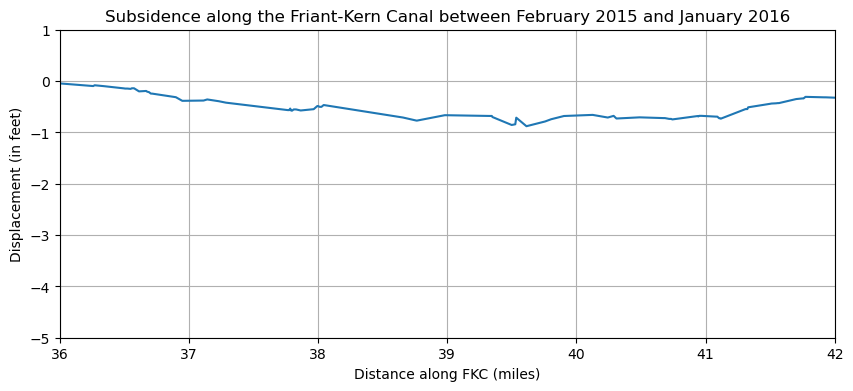

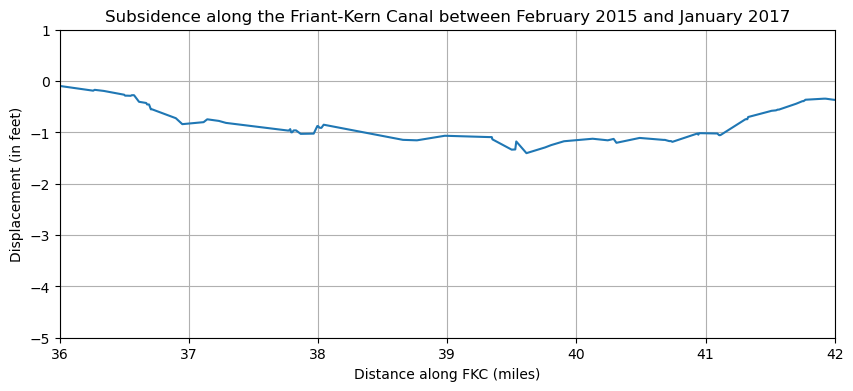

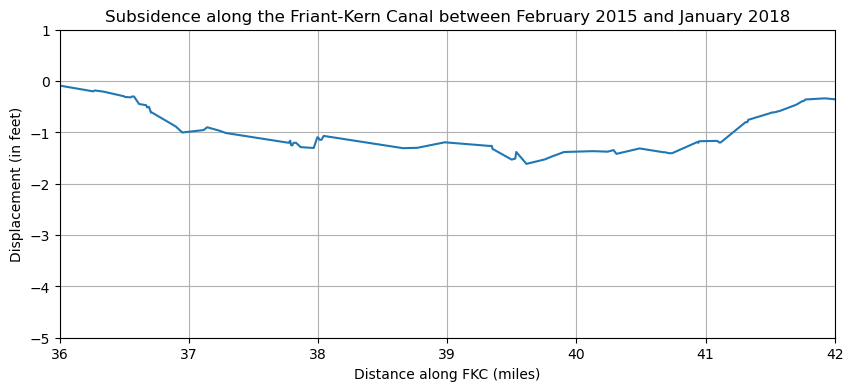

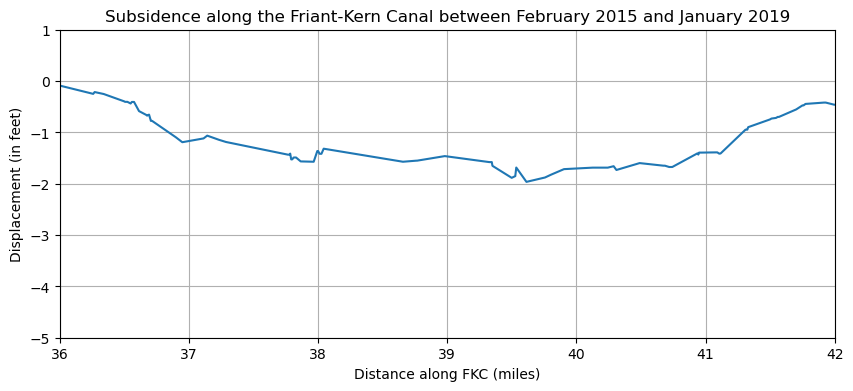

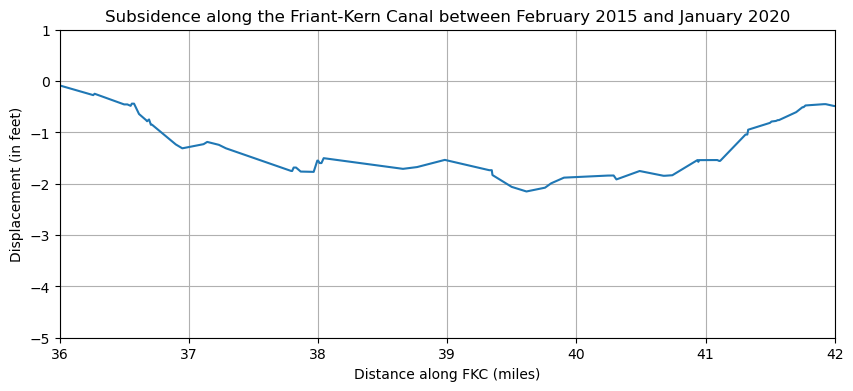

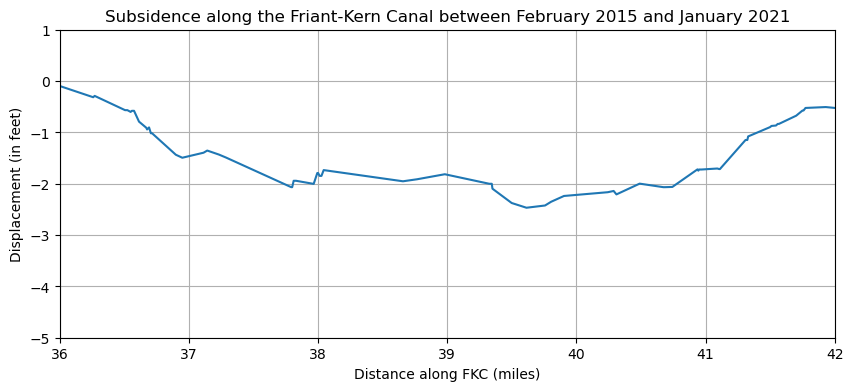

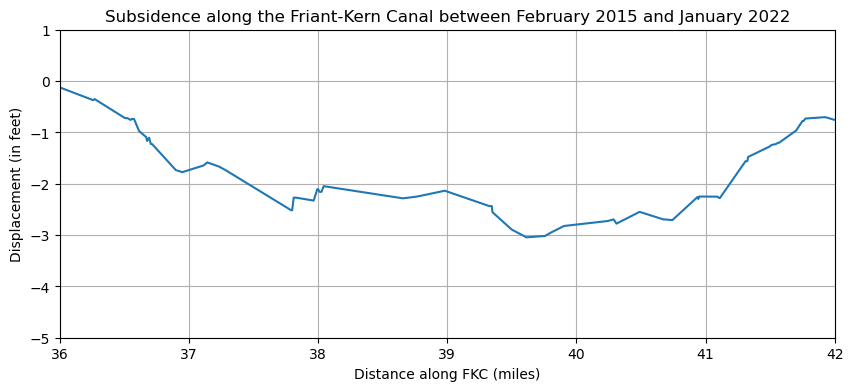

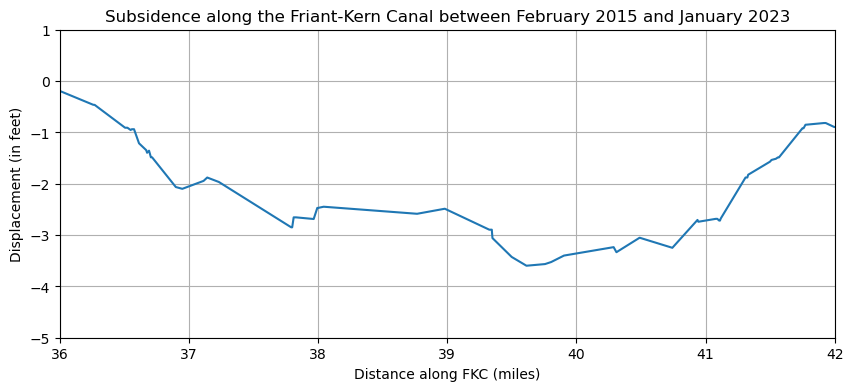

In [25]:
for dt in pd.date_range(start="01-01-2016", periods=8, freq="YS"):
    dplt = cleaned_data[cleaned_data["Date"] == dt].sort_values(by="distance_along")
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(dplt["distance_along"]/5280, dplt["Subsidence"]/25.4/12, label=dt.strftime("%Y-%m-%d"))
    
    # format plot
    ax.set_title(f"Subsidence along the Friant-Kern Canal between February 2015 and {dt.strftime('%B %Y')}")
    ax.set_xlabel("Distance along FKC (miles)")
    ax.set_ylabel("Displacement (in feet)")
    ax.set_ylim(-5, 1)
    ax.set_xlim(36, 42)
    ax.grid()

In [42]:
for dt in pd.date_range(start="01-01-2016", periods=8, freq="YS"):
    dplt = cleaned_data[cleaned_data["Date"] == dt].sort_values(by="distance_along")
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(dplt["distance_along"]/5280, dplt["Subsidence"]/25.4/12, label=dt.strftime("%Y-%m-%d"))
    
    # format plot
    ax.set_title(f"Subsidence along the Friant-Kern Canal between February 2015 and {dt.strftime('%B %Y')}")
    ax.set_xlabel("Distance along FKC (miles)")
    ax.set_ylabel("Displacement (in feet)")
    ax.set_ylim(-5, 1)
    ax.set_xlim(0, 51)
    
    # add GSA Boundaries
    ax.axvline(112150/5280, color="gray")
    ax.axvline(184500/5280, color="gray")
    ax.axvline(240275/5280, color="gray")
    
    # add GSA labels
    ax.text(0.22, 0.1, 'Kings Subbasin', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    ax.text(0.55, 0.1, 'Kaweah Subbasin', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    ax.text(0.78, 0.1, 'Tule Subbasin', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    ax.text(0.95, 0.1, 'Kern\nSubbasin', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

    fig.subplots_adjust(right=0.8)

    lax = fig.add_axes([0.81, 0.1, 0.09, 0.09])
    lax.imshow(intera_logo)
    lax.axis("off")
    
    plt.savefig(f"FKC_Displacement_{dt.strftime('%Y%m%d')}.png")
    plt.close()   

# Export Data

In [153]:
cleaned_data[["CODE", "StartDate", "Date", "Subsidence", "distance_along"]].to_csv("FKC_Subsidence_InSAR.csv", index=False)

In [168]:
gpd.GeoDataFrame(cleaned_data[["CODE", "distance_along", "geometry"]].groupby("CODE").last().reset_index(), crs=fkc_pts_w_insar.crs).to_file("FKC_Subsidence_InSAR.shp")

C:\Users\hatch\AppData\Local\Temp\ipykernel_6432\2514258853.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gpd.GeoDataFrame(cleaned_data[["CODE", "distance_along", "geometry"]].groupby("CODE").last().reset_index(), crs=fkc_pts_w_insar.crs).to_file("FKC_Subsidence_InSAR.shp")


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["LON"], df["LAT"]), crs="EPSG:4326")